In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('tableau-colorblind10')

# Define the path to the src directory manually
src_path = os.path.abspath('../src')
sys.path.insert(0, src_path)

# Load constants
from constUnitConvert import ConstantsUnitConversion
from constGlobal import ConstantsGlobal

CONVERT = ConstantsUnitConversion()
GLOBAL = ConstantsGlobal()

# import the TidalData class from the module_tidal module
from module_tidal import TidalData
from module_rotor import RotorData
from module_rotor_simulation import RotorSimulation
from module_constraint_checker import ConstraintChecker
from module_vessel import VesselData
from module_lcoe import LCOE
from module_battery_charging import BatteryCharging


# Step 1: Load tidal data

/Users/akeow/opt/anaconda3/envs/VITAL_env/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'proxy.sandia.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/akeow/opt/anaconda3/envs/VITAL_env/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'proxy.sandia.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/akeow/opt/anaconda3/envs/VITAL_env/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'proxy.sandia.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#t

Mooring Distance (m): 50.0
Latitude (radians): 0.9891915335065662
Longitude (radians): -2.3340724419233165
Station Name: Summit Island, west of
Nearest City: Kake
Cable Length (m): 41236.37


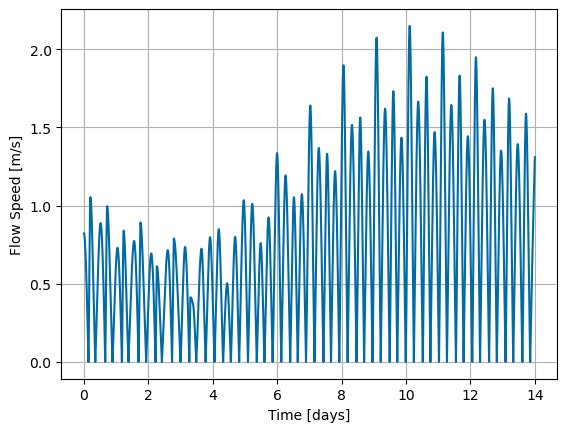

In [2]:
# define the parameters required to initialize the TidalData class
# station identifier, start date, range in hours, and time step in seconds
my_station = "PCT3716"  # Site 2
my_startdate = 20200201  # yyyyMMdd
my_rangeHr = 2 * 7 * 24  # Two weeks
my_timestep = 1.0  # Timestep in seconds

# create an instance of the TidalData class using the parameters defined
tidal_data = TidalData(my_station, my_startdate, my_rangeHr, my_timestep)

# specify the path to the city coordinate file  
# use the load_tidal_data method to load the tidal data
CityCoordinateFile = "../data/AlaskaCityLatLong.txt"
flow_speeds, times, dmoor_m, lat_rad, lon_rad, station_name, nearest_city, cable_length = tidal_data.load_tidal_data(CityCoordinateFile)

# Display the loaded data
print("Mooring Distance (m):", dmoor_m)
print("Latitude (radians):", lat_rad)
print("Longitude (radians):", lon_rad)
print("Station Name:", station_name)
print("Nearest City:", nearest_city)
print("Cable Length (m):", cable_length)

# Plot the flow speeds over time
plt.figure()
plt.plot(times / (24 * 3600), flow_speeds)
plt.xlabel('Time [days]')
plt.ylabel('Flow Speed [m/s]') 
plt.grid()
plt.show()

# Step 2: Load rotor performance map

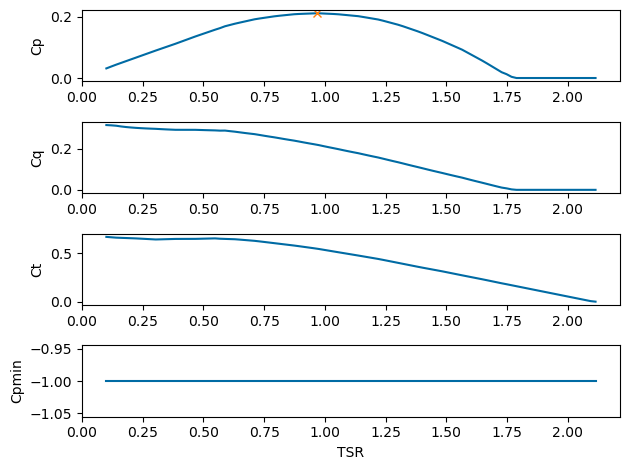

In [3]:
# Use either one
# Sitkana Rotor Data
RotorPerformanceFile = "../data/Sitkana_rotor_data_blade_1.txt"
rotor_data = RotorData(RotorPerformanceFile)

# # HDPS Rotor Data
# RotorPerformanceFile = "../data/Sandia_rotor_data.txt"
# cpmin_filename = "../data/Cpmin_data.json"
# rotor_data = RotorData(RotorPerformanceFile,cpmin_filename)

# Temporary array to visualise the performance map 
TSR_val = np.linspace(0.1,rotor_data.TSRmax,100)

plt.figure(figsize=(6.4,4.8))
plt.subplot(4,1,1)
plt.plot(TSR_val,rotor_data.get_cp(TSR_val))
plt.plot(rotor_data.TSROpt,rotor_data.CpOpt,'x')
plt.ylabel('Cp') 
# plt.grid() 

plt.subplot(4,1,2)
plt.plot(TSR_val,rotor_data.get_cq(TSR_val))
plt.ylabel('Cq') 
# plt.grid() 

plt.subplot(4,1,3)
plt.plot(TSR_val,rotor_data.get_ct(TSR_val))
plt.ylabel('Ct') 
# plt.grid()

plt.subplot(4,1,4)
plt.plot(TSR_val,rotor_data.get_cpmin(TSR_val))
plt.ylabel('Cpmin') 
# plt.grid()

plt.xlabel('TSR')
plt.tight_layout()
plt.show()

# Step 3: Build turbine configuration dictionary

In [4]:
# Define simulation parameters
my_radius = 1.0
my_prated = 1000.0
my_dCable = 15.0 # This is for the length of the attachment below the platform for the turbine (NOT electrical cable)

my_cutinSpeed = 0.1
my_brake = True

# my_controlStrategy = 'optimal'                # 'optimal' or 'constant_speed'
my_controlStrategy = 'constant_speed'           # 'optimal' or 'constant_speed'

my_attachment = 'solid_bar'                 # 'solid_bar' or 'cable'
# my_attachment = 'cable'                 # 'solid_bar' or 'cable'

my_system_efficiency = 0.9

# Create dictonary to store simulation condition
config = {
    'Radius': my_radius,                    # user defined
    'Prated': my_prated,                    # user defined
    'dCable': my_dCable,                    # user defined
    'Umin': my_cutinSpeed,                  # user defined
    'withBrake': my_brake,                  # user defined
    'control_strategy': my_controlStrategy, # user defined
    'attachment_method': my_attachment,     # user defined
    'efficiency': my_system_efficiency,     # user defined
    'dMoor': dmoor_m,                       # From TidalData class
    'Uinf': flow_speeds,                    # From TidalData class
    't': times,                             # From TidalData class
    'CpFunc': rotor_data.get_cp,            # From RotorData class
    'CqFunc': rotor_data.get_cq,            # From RotorData class
    'CtFunc': rotor_data.get_ct,            # From RotorData class
    'CpOpt': rotor_data.CpOpt,              # From RotorData class
    'TSROpt': rotor_data.TSROpt,            # From RotorData class
    'TSRmax': rotor_data.TSRmax,            # From RotorData class
}

# Step 4: Run simulation

In [5]:

# Run the simulation
rotor_sim = RotorSimulation(config)
rotor_sim.simulate()
result = rotor_sim.get_results()



Optimal Speed is 1.1892600756915968


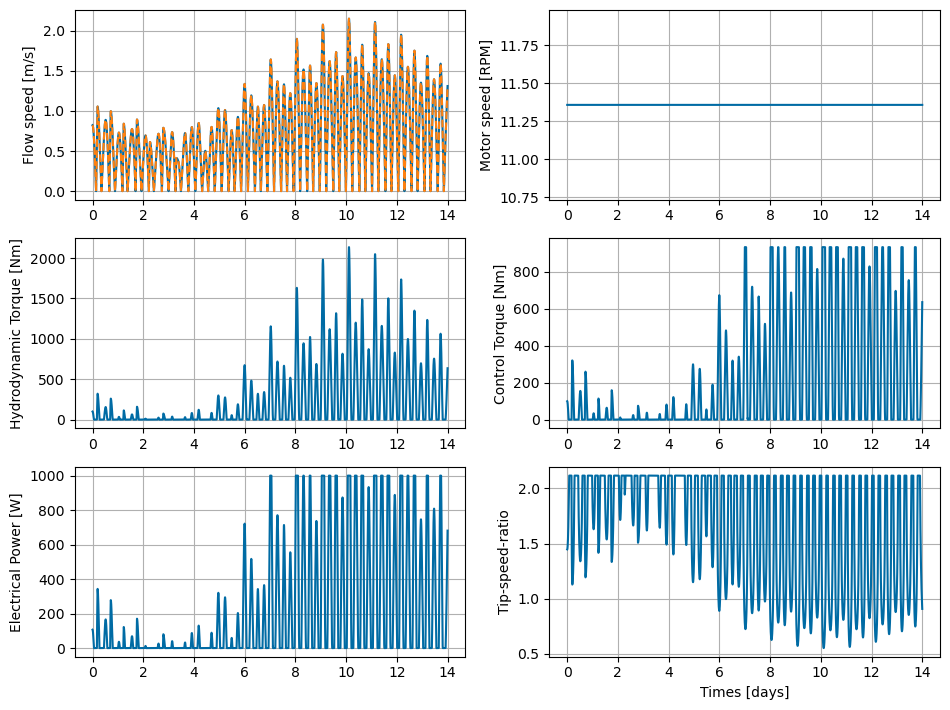

In [6]:
# Plot simulation results
plt.figure(figsize=(6.4/2*3,4.8/2*3))
plt.subplot(3,2,1)
plt.plot(result['t']/(24*3600),result['Uinf_adjusted'])
plt.plot(times/(24*3600),flow_speeds,'--')
plt.grid(True)
plt.ylabel('Flow speed [m/s]')

plt.subplot(3,2,2)
plt.plot(result['t']/(24*3600),result['w']*CONVERT.rads2rpm) 
plt.grid(True)
plt.ylabel('Motor speed [RPM]')

plt.subplot(3,2,3)
plt.plot(result['t']/(24*3600),result['Th']) 
plt.grid(True)
plt.ylabel('Hydrodynamic Torque [Nm]')

plt.subplot(3,2,4)
plt.plot(result['t']/(24*3600),result['Tc']) 
plt.grid(True)
plt.ylabel('Control Torque [Nm]')

plt.subplot(3,2,5)
plt.plot(result['t']/(24*3600),result['Pelec']) 
plt.grid(True)
plt.ylabel('Electrical Power [W]')

plt.subplot(3,2,6)
plt.plot(result['t']/(24*3600),result['TSR']) 
plt.grid(True)
plt.ylabel('Tip-speed-ratio')

plt.xlabel('Times [days]')
plt.tight_layout()
plt.show()


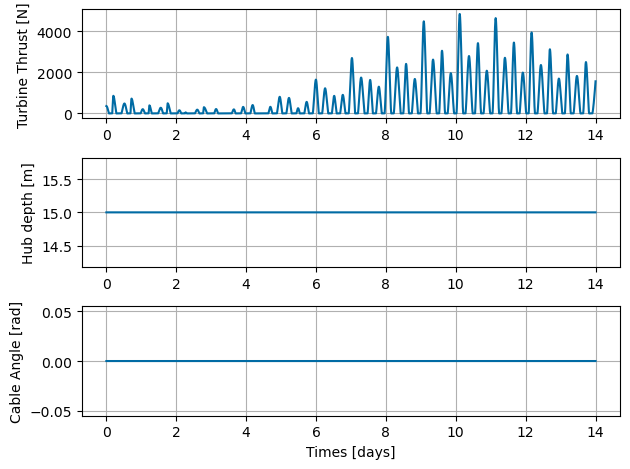

In [7]:

# Plot varying rotor depth 
plt.subplot(3,1,1)
plt.plot(result['t']/(24*3600),result['Ft']) 
plt.grid(True)
plt.ylabel('Turbine Thrust [N]')

plt.subplot(3,1,2)
plt.plot(result['t']/(24*3600),result['dHub']) 
plt.grid(True)
plt.ylabel('Hub depth [m]')

plt.subplot(3,1,3)
plt.plot(result['t']/(24*3600),result['theta_turbine']*180/np.pi) 
plt.grid(True)
plt.ylabel('Cable Angle [rad]')

plt.xlabel('Times [days]')
plt.tight_layout()
plt.show()

# Step 5: Define vessel

In [8]:
my_numTurbine = 10

user_vessel_properties = {
    'Xm': 5.77,
    'Zm': 1.65,
    'Kphi': 1.95e6,
    'theta': 45.0 * np.pi / 180.0,
    'phi': 10.0 * np.pi / 180.0,
    'area': 2.25,
    'Cd': 1.0
}


# initialize classes
vessel = VesselData(
    user_defined=True,
    vessel_properties=user_vessel_properties
)

Vessel_Drag_Force = vessel.calculate_vessel_drag_force(result['Uinf_adjusted'])

# vessel.print_all_attributes()
# plt.plot(Vessel_Drag_Force)

# If designing vessel
my_vessel_height = 0.5
my_vessel_density = 500.0
my_vessel_theta_m = 45/180*np.pi
my_vessel_aspect_ratio = 4
my_vessel_Cd = 1.0
my_vessel_phi = 10/180*np.pi

vessel = VesselData(height = my_vessel_height,
                    density = my_vessel_density,
                    theta_m = my_vessel_theta_m,
                    alpha = my_vessel_aspect_ratio,
                    Cd = my_vessel_Cd,
                    phi = my_vessel_phi,
                    user_defined = False)

vessel.calculate_vessel_properties(result['Wturbine']/GLOBAL.g,
                                   result['Uinf_adjusted'],
                                   result['Ft'],
                                   my_numTurbine)

Vessel_Drag_Force = vessel.calculate_vessel_drag_force(result['Uinf_adjusted'])

# vessel.print_all_attributes()
# plt.plot(Vessel_Drag_Force,'--')

# Step 6: Check constraint vessel

In [9]:


# # Reload the module
# import importlib
# import module_constraint_checker  # Import the module itself
# importlib.reload(module_constraint_checker)

# # Re-import the specific class
# from module_constraint_checker import ConstraintChecker

constraint_checker = ConstraintChecker(my_radius, rotor_data.get_cpmin, config)

depth_constraint_satisfied = constraint_checker.check_depth_constraint(result['dHub'])
cavitation_constraint_satisfied = constraint_checker.check_cavitation_constraint(result['TSR'], result['Uinf_adjusted'], result['w'], result['dHub'])
pitch_constraint_satisfied = constraint_checker.check_pitch_constraint(vessel, result['Uinf_adjusted'], result['Ft'], result['dHub'], my_numTurbine)

if depth_constraint_satisfied:
    print(f'Depth constraint satisfied')

if cavitation_constraint_satisfied:
    print(f'Cavitation constraint satisfied')

if pitch_constraint_satisfied:
    print(f'Pitch constraint satisfied')

USING designed_pitch_constraint()
Depth constraint satisfied
Cavitation constraint satisfied
Pitch constraint satisfied


# Step 7: Check LCOE

In [10]:
my_turbinelifetime = 10
my_discount_rate = 0.1
my_turbulence_intensity = 0.0
my_batteryCapacity = 10.0

lcoe_calculator = LCOE(
                        turbine_radius=my_radius, 
                        turbine_rated_power=my_prated, 
                        number_of_turbines=my_numTurbine, 
                        hub_depth=result['dHub'], 
                        lifetime=my_turbinelifetime,
                        discount_rate=my_discount_rate,
                        turbulence_intensity=my_turbulence_intensity,
                        customer='customer_A', 
                        # application='battery_charging',
                        application='grid_connection',
                       )

lcoe_calculator.set_instantaneous_power(result['Pelec'], result['t'])

# Calculate and print the annual energy production
annual_energy = lcoe_calculator.calculate_annual_energy()  # Call the method
print(f'Produce {annual_energy} kWh of power annually')

Produce 19349.001258902324 kWh of power annually


In [11]:


lcoe = lcoe_calculator.calculate_lcoe(cable_length, 
                                      dmoor_m, 
                                        Vessel_Drag_Force, 
                                        result['Ft'], 
                                        vessel.VesselVolume, 
                                        BatteryCapacity_kWh = my_batteryCapacity)

Individual CAPEX components:
blade_cost: $551.49
generator_cost: $5554.79
misc_cost: $470.02
mooring_cost: $8755.56
electrical_cable_cost: $293665.63
grid_connection_cost: $284.86
hub_cost: $2107.97
cable_installation_cost: $1168706.56


In [12]:
lcoe

np.float64(16.284404790340826)

# Step 8: Battery charging application

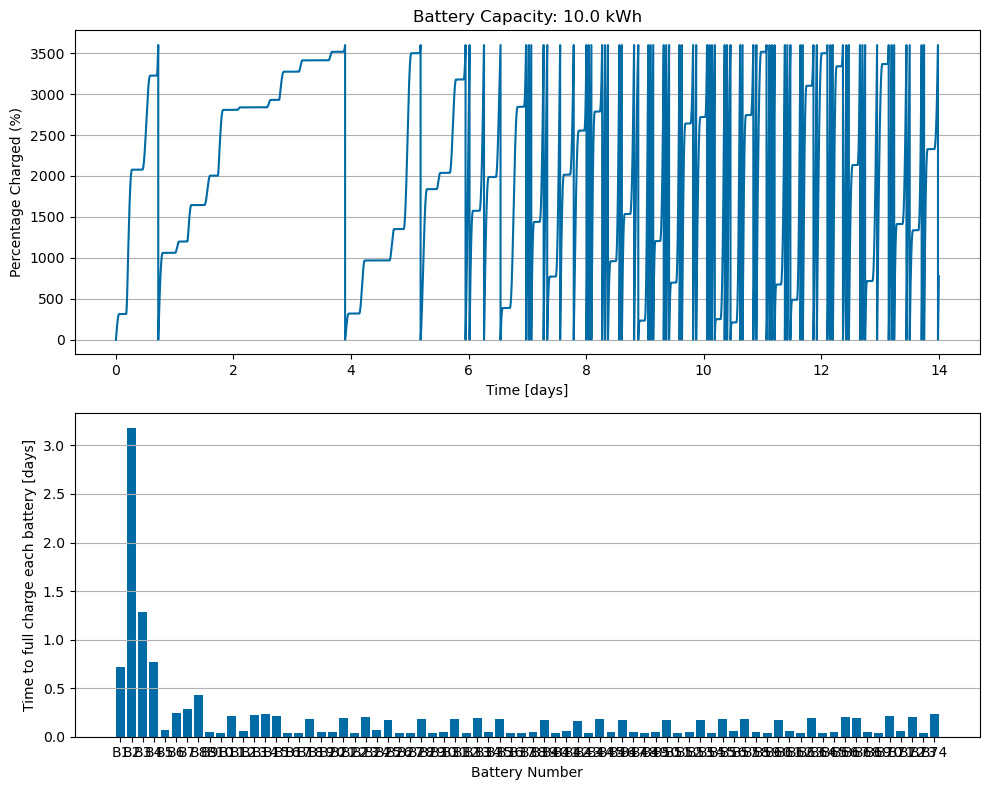

In [13]:
battery_charging = BatteryCharging(my_batteryCapacity, my_numTurbine, my_turbulence_intensity)
num_batteries_charged, charge_times_hr = battery_charging.chargeBattery_continuous(result['Pelec'], result['t'], visualise=True)


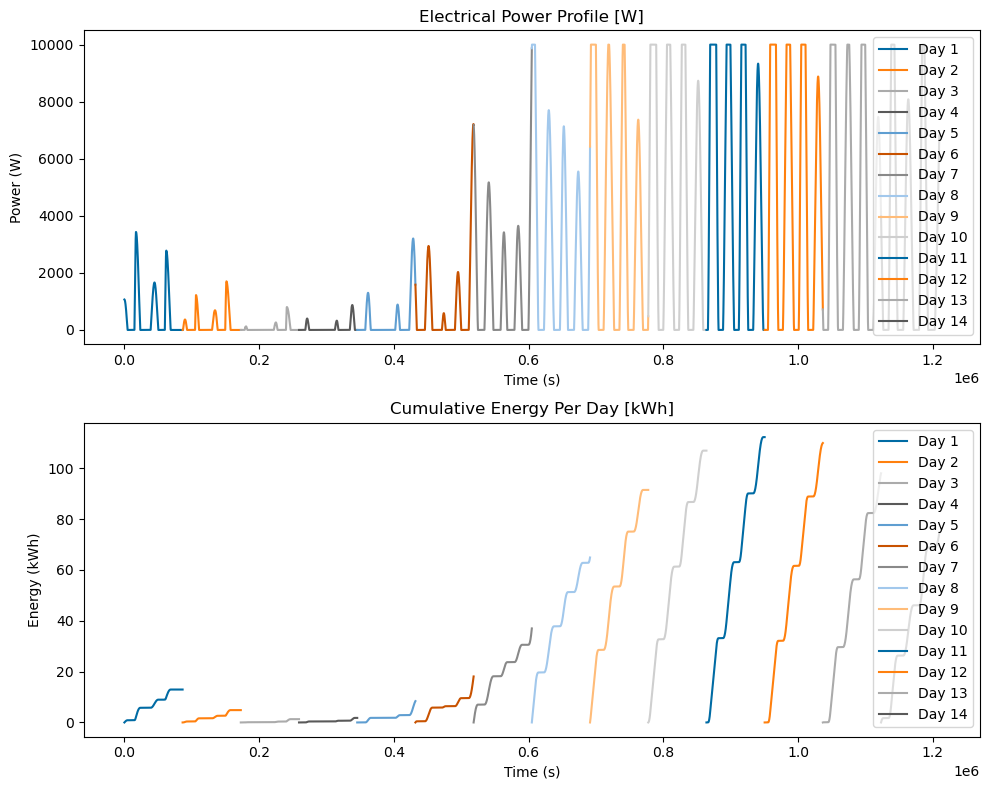

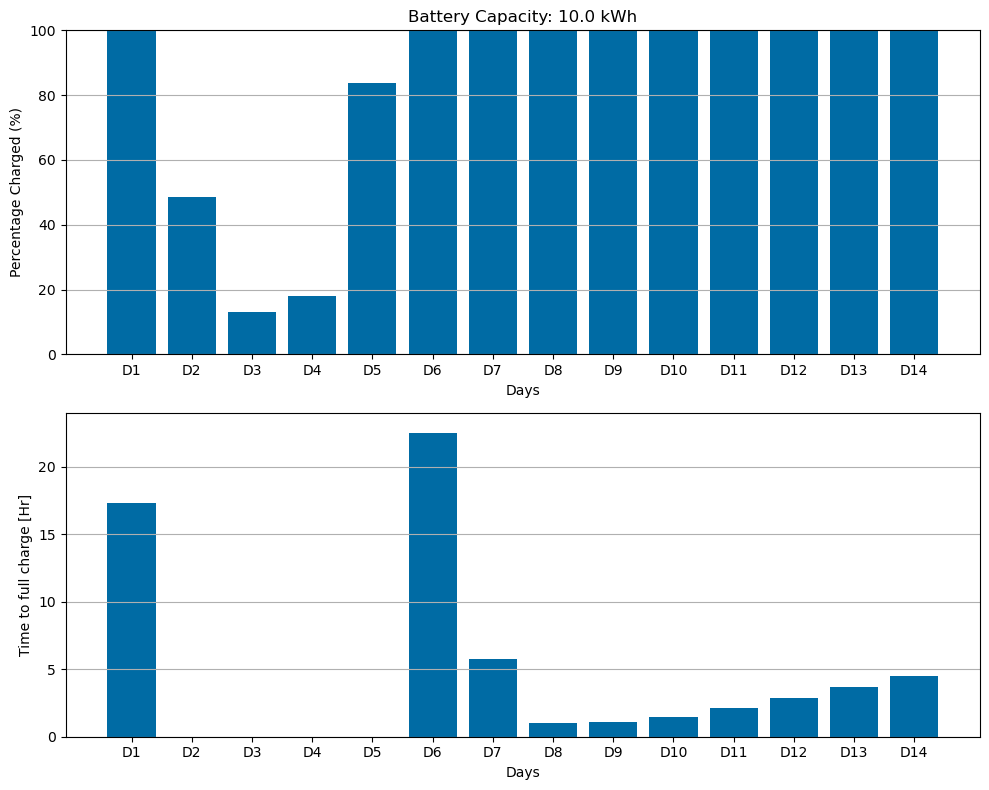

In [14]:
battery_charging_per_day_results = battery_charging.chargeBattery_perDay(result['Pelec'], result['t'], visualise=True)
